scheme:

* 1) for data transfer, pick 1st sleep api (h2d) fo stream-0, current cc = 1 (concurrency),
* 2) check whether there is overalp with stream-
* 2) if there is overlap, finish cc=1, start from cc++ (cc=2), predit the future ending time
* 3) during the predicted ending time, check whether there is overlap with stream-2
* 4) if there is overalap, finish cc=2, start from cc++ (cc=3), predict the future ending time
* 5) go to step 3) , search through all the cuda streams
* 6) for each time range, we need to find out how many apis have overlap and which-pair have conflicts or not

In [259]:
%load_ext autoreload
%autoreload 2

import warnings
import pandas as pd
import numpy as np
import os
import sys # error msg, add the modules
import operator # sorting
from math import *
import matplotlib.pyplot as plt

sys.path.append('../../')

import cuda_timeline
import read_trace
import avgblk
import cke
from model_param import *
from df_util import *

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# gpu info

In [260]:
gtx950 = DeviceInfo()
gtx950.sm_num = 6
gtx950.sharedmem_per_sm = 49152
gtx950.reg_per_sm = 65536
gtx950.maxthreads_per_sm = 2048

In [261]:
# init SM resources
SM_resList, SM_traceList = init_gpu(gtx950)

In [262]:
#SM_resList[0]

In [263]:
SM_traceList[0]

,sm_id,block_id,block_start,block_end,batch_id,kernel_id,active


# Understand the input

In [264]:
trace_s1 = 'trace_s1_5m.csv'
df_trace_s1 = read_trace.Trace2dataframe(trace_s1)

trace_s2 = 'trace_s2_5m.csv'
df_trace_s2 = read_trace.Trace2dataframe(trace_s2)

trace_s3 = 'trace_s3_5m.csv'
df_trace_s3 = read_trace.Trace2dataframe(trace_s3)

In [265]:
df_trace_s1

,Start,Duration,Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem,Dynamic SMem,Size,Throughput,Device,Context,Stream,Name
0,ms,ms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,MB,GB/s,NaN,NaN,NaN,NaN
1,618.396387,3.187298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.073486,5.843963,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy HtoD]
2,621.584901,3.195713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.073486,5.828575,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy HtoD]
3,624.787590,11.914429,19532.0,1.0,1.0,256.0,1.0,1.0,28.0,0,0,NaN,NaN,GeForce GTX 950 (0),1.0,13.0,"kernel_vectorAdd(float const *, float const *,..."
4,636.707395,3.134849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.073486,5.941738,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy DtoH]


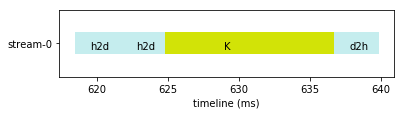

In [266]:
cuda_timeline.plot_trace(df_trace_s1)

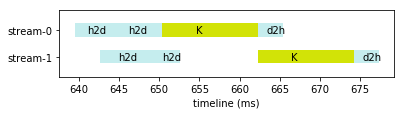

In [267]:
cuda_timeline.plot_trace(df_trace_s2)

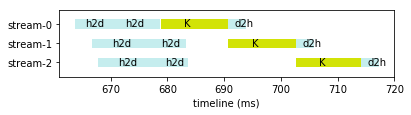

In [268]:
cuda_timeline.plot_trace(df_trace_s3)

# Kernel Info from the single stream

In [269]:
# extract kernel info from trace
# warning: currently lmted to one kernel

kernel = read_trace.GetKernelInfo(df_trace_s1, gtx950)

Dump_kernel_info(kernel)

Kernel Info
		blockDim 256.0
		gridkDim 19532.0
		regs 28.0
		shared memory 0.0
		runtime (ms) 11.914429
		average block execution time (ms) 0.0292737813268
		start time (ms) 0


# model 3 cuda streams

In [270]:
# for each stream, have a dd for each kernel
stream_kernel_list = []

stream_num = 3

for sid in range(stream_num):
    #print sid
    # key will be the kernel order
    # value will be the kernel info
    kern_dd = {}
    kern_dd[0] = Copy_kernel_info(kernel)
    stream_kernel_list.append(kern_dd)
    
    
Dump_kernel_info(stream_kernel_list[0][0])

Kernel Info
		blockDim 256.0
		gridkDim 19532.0
		regs 28.0
		shared memory 0.0
		runtime (ms) 11.914429
		average block execution time (ms) 0.0292737813268
		start time (ms) 0


### start kernel from beginning

In [271]:
df_s1_trace_timing = read_trace.Get_timing_from_trace(df_trace_s1)
df_s1 = read_trace.Reset_starting(df_s1_trace_timing)

In [272]:
df_s1

,stream,api_type,start,end,size,duration
0,0.0,h2d,0.000000,3.187298,19073.486,3.187298
1,0.0,h2d,3.188514,6.384227,19073.486,3.195713
2,0.0,kern,6.391203,18.305632,0.000,11.914429
3,0.0,d2h,18.311008,21.445857,19073.486,3.134849


### set the h2d start for all the cuda streams

In [273]:
# find when to start the stream and update the starting pos for the trace
H2D_H2D_OVLP_TH = 3.158431

df_cke_list = cke.init_trace_list(df_s1, stream_num = stream_num, h2d_ovlp_th = H2D_H2D_OVLP_TH)

stream_startTime : 3.160431
stream_startTime : 6.320862


In [274]:
df_cke_list[0]

,stream,api_type,start,end,size,duration
0,0,h2d,0.000000,3.187298,19073.486,3.187298
1,0,h2d,3.188514,6.384227,19073.486,3.195713
2,0,kern,6.391203,18.305632,0.000,11.914429
3,0,d2h,18.311008,21.445857,19073.486,3.134849


In [275]:
df_cke_list[1]

,stream,api_type,start,end,size,duration
0,1,h2d,3.160431,6.347729,19073.486,3.187298
1,1,h2d,6.348945,9.544658,19073.486,3.195713
2,1,kern,9.551634,21.466063,0.000,11.914429
3,1,d2h,21.471439,24.606288,19073.486,3.134849


In [276]:
df_cke_list[2]

,stream,api_type,start,end,size,duration
0,2,h2d,6.320862,9.508160,19073.486,3.187298
1,2,h2d,9.509376,12.705089,19073.486,3.195713
2,2,kern,12.712065,24.626494,0.000,11.914429
3,2,d2h,24.631870,27.766719,19073.486,3.134849


### merge all the cuda stream trace together

In [277]:
df_all_api = cke.init_sort_api_with_extra_cols(df_cke_list)

In [278]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,pred_end
0,0.000000,3.187298,h2d,19073.486,0.0,sleep,5984.217980,0.0,19073.486,0.0,0.0
4,3.160431,6.347729,h2d,19073.486,1.0,sleep,5984.217980,0.0,19073.486,0.0,0.0
1,3.188514,6.384227,h2d,19073.486,0.0,sleep,5968.460247,0.0,19073.486,0.0,0.0
8,6.320862,9.508160,h2d,19073.486,2.0,sleep,5984.217980,0.0,19073.486,0.0,0.0
5,6.348945,9.544658,h2d,19073.486,1.0,sleep,5968.460247,0.0,19073.486,0.0,0.0
2,6.391203,18.305632,kern,0.000,0.0,sleep,0.000000,0.0,0.000,0.0,0.0
9,9.509376,12.705089,h2d,19073.486,2.0,sleep,5968.460247,0.0,19073.486,0.0,0.0
6,9.551634,21.466063,kern,0.000,1.0,sleep,0.000000,0.0,0.000,0.0,0.0
10,12.712065,24.626494,kern,0.000,2.0,sleep,0.000000,0.0,0.000,0.0,0.0
3,18.311008,21.445857,d2h,19073.486,0.0,sleep,6084.339628,0.0,19073.486,0.0,0.0


### start algorithm

In [279]:
# stream_id list
stream_list = [float(x) for x in range(stream_num)]

# pick the 1st sleep api
df_all_api, r1, r1_stream = cke.pick_first_sleep(df_all_api)
print('row {}, stream-id {}'.format(r1, r1_stream))

# extract api calls from other streams
df_other = df_all_api.loc[df_all_api.stream_id <> r1_stream]

other_stream_ids = list(df_other.stream_id.unique())
other_stream_num = len(other_stream_ids)
for i in range(other_stream_num):
    df_all_api, r2, r2_stream = cke.pick_first_sleep(df_other)

# other_stream_list = cke.find_unique_streams(df_other)

# find the 1st sleep api that is other stream
# if there is overlapping, we start ovlp mode, if not finish r1, start current





# go through each 

# rest_stream_list = [x  for x in stream_list if x <> r1_stream]
# print rest_stream_list

# for sid in rest_stream_list:
#     df_stream = df_all_api.loc[df_all_api.stream_id == sid]



row 0, stream-id 0.0
[1.0, 2.0]


In [280]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,pred_end
0,0.000000,3.187298,h2d,19073.486,0.0,wake,5984.217980,0.0,19073.486,0.0,0.0
4,3.160431,6.347729,h2d,19073.486,1.0,sleep,5984.217980,0.0,19073.486,0.0,0.0
1,3.188514,6.384227,h2d,19073.486,0.0,sleep,5968.460247,0.0,19073.486,0.0,0.0
8,6.320862,9.508160,h2d,19073.486,2.0,sleep,5984.217980,0.0,19073.486,0.0,0.0
5,6.348945,9.544658,h2d,19073.486,1.0,sleep,5968.460247,0.0,19073.486,0.0,0.0
2,6.391203,18.305632,kern,0.000,0.0,sleep,0.000000,0.0,0.000,0.0,0.0
9,9.509376,12.705089,h2d,19073.486,2.0,sleep,5968.460247,0.0,19073.486,0.0,0.0
6,9.551634,21.466063,kern,0.000,1.0,sleep,0.000000,0.0,0.000,0.0,0.0
10,12.712065,24.626494,kern,0.000,2.0,sleep,0.000000,0.0,0.000,0.0,0.0
3,18.311008,21.445857,d2h,19073.486,0.0,sleep,6084.339628,0.0,19073.486,0.0,0.0


In [ ]:
#
#
# run above

### start algo

In [24]:
count = 0
# break_count = 7
break_count = 7

while not cke.AllDone(df_all_api):
    count = count + 1
    #if count == break_count: break
    
    #-----------------------
    # pick two api to model 
    #-----------------------
    df_all_api, r1, r2 = cke.PickTwo(df_all_api)
    
    #if count == break_count: break

    #-----------------------
    # check the last api or not 
    #-----------------------
    last_api = False
    if r1 == None and r2 == None:
        last_api = True
        
    if last_api == True:                          # go directly updating the last wake api
        df_all_api = cke.UpdateStream_lastapi(df_all_api)
        break
    
    
    #-----------------------
    # move the current_pos to the starting of coming api r2, and update r1 status
    #-----------------------
    df_all_api = cke.StartNext_byType(df_all_api, [r1, r2])
    
    #if count == break_count: break

    #-----------------------------
    # if one call is done, continue the next round
    #-----------------------------
    if cke.CheckRowDone(df_all_api, r1, r2):
        continue
        
    #if count == break_count: break
        
    #-----------------------------
    # when all calls are active
    #-----------------------------
    
    #-----------------------------
    # check whether the two calls are kerns, if yes
    #-----------------------------
    whichType = cke.CheckType(df_all_api, r1, r2) # check whether the same api
    if whichType == None:
        df_all_api = cke.Predict_noConflict(df_all_api, r1, r2)
    elif whichType in ['h2d', 'd2h']: # data transfer in the same direction
        df_all_api = cke.Predict_transferOvlp(df_all_api, r1, r2, ways = 2.0)
    else: # concurrent kernel: todo
        print('run cke model')
        
        #cke.model_2cke(df_all_api, r1, r2)
        #if count == break_count: break
            
        r1_sid, r1_kid =cke.FindStreamAndKernID(df_all_api, r1)
        #print('r1_stream_id {} , r1_kernel_id {}'.format(r1_sid, r1_kid))
        r2_sid, r2_kid =cke.FindStreamAndKernID(df_all_api, r2)
        #print('r2_stream_id {} , r2_kernel_id {}'.format(r2_sid, r2_kid))
        r1_start_ms = cke.GetStartTime(df_all_api, r1)
        r2_start_ms = cke.GetStartTime(df_all_api, r2)
        
        #print r1_start_ms
        #print r2_start_ms
        
        #print('before:')
        #print('r1 start :{} r2 start : {}'.format(stream_kernel_list[r1_sid][r1_kid].start_ms,
        #                                         stream_kernel_list[r2_sid][r2_kid].start_ms))
        
        stream_kernel_list[0][0].start_ms = r1_start_ms
        stream_kernel_list[1][0].start_ms = r2_start_ms
        
        
        #print('after:')
        #print('r1 start :{} r2 start : {}'.format(stream_kernel_list[r1_sid][r1_kid].start_ms,
        #                                        stream_kernel_list[r2_sid][r2_kid].start_ms))
        

        #Dump_kern_info(stream_kernel_list[r1_sid][r1_kid])
        #Dump_kern_info(stream_kernel_list[r2_sid][r2_kid])
        
        kernels_ = []
        kernels_.append(stream_kernel_list[r1_sid][r1_kid])
        kernels_.append(stream_kernel_list[r2_sid][r2_kid])

        SM_resList, SM_traceList = avgblk.cke_model(gtx950, SM_resList, SM_traceList, kernels_)
        
        # find the kernel execution time from the sm trace table
        result_kernel_runtime_dd = avgblk.Get_KernTime(SM_traceList)
        
        #print result_kernel_runtime_dd
        
        result_r1_start = result_kernel_runtime_dd[0][0]
        result_r1_end = result_kernel_runtime_dd[0][1]
        
        result_r2_start = result_kernel_runtime_dd[1][0]
        result_r2_end = result_kernel_runtime_dd[1][1]
        
        # r1 will be the 1st in dd, r2 will be the 2nd 
        df_all_api.set_value(r1, 'pred_end', result_r1_end)
        df_all_api.set_value(r2, 'pred_end', result_r2_end)   # Warning: it is better to have a pred_start
                                                              # Warning: but we care about the end timing for now

        
    #if count == break_count: break
        
        

    # check any of r1 and r2 has status done. if done, go to next 


    rangeT = cke.Get_pred_range(df_all_api)
    print rangeT

    #if count == break_count: break

    extra_conc = cke.Check_cc_by_time(df_all_api, rangeT) # check whether there is conc during the rangeT
    print('extra_conc {}'.format(extra_conc))
    
    #if count == break_count: break
        
    if extra_conc == 0:
        if whichType in ['h2d', 'd2h']:
            df_all_api = cke.Update_wake_transferOvlp(df_all_api, rangeT, ways = 2.0)
        elif whichType == 'kern':
            df_all_api = cke.Update_wake_kernOvlp(df_all_api)
        else: # no overlapping
            df_all_api = cke.Update_wake_noConflict(df_all_api, rangeT)

        #if count == break_count: break
            
        # check if any api is done, and update the timing for the other apis in that stream
        df_all_api = cke.UpdateStreamTime(df_all_api)
        
        #if count == break_count: break

    else: # todo : when there is additional overlapping
        pass

#         if count == break_count:
#             break
        


row:0 row:1
row:1 row:4
row:4 row:5
row:5 row:2
row:2 row:6
run cke model
[0.23682000000001335, 0.25757199999998193]
extra_conc 0
row:3 row:7
row:None row:None


In [25]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,pred_end
0,0.000000,0.016641,h2d,89.84375,0.0,done,5398.939367,89.84375,0.0,0.016641,0.016641
1,0.018081,0.034209,h2d,89.84375,0.0,done,5570.669023,89.84375,0.0,0.034209,0.034209
4,0.036209,0.052850,h2d,89.84375,1.0,done,5398.939367,89.84375,0.0,0.052850,0.052850
5,0.054290,0.070418,h2d,89.84375,1.0,done,5570.669023,89.84375,0.0,0.070418,0.070418
2,0.200611,0.257572,kern,0.00000,0.0,done,0.000000,0.00000,0.0,0.257572,0.257572
6,0.236820,0.314533,kern,0.00000,1.0,done,0.000000,0.00000,0.0,0.314533,0.314533
3,0.263236,0.279141,d2h,89.84375,0.0,done,5648.773970,89.84375,0.0,0.279141,0.279141
7,0.320197,0.336102,d2h,89.84375,1.0,done,5648.773970,89.84375,0.0,0.336102,0.336102


In [26]:
df_2stream_trace

,stream,api_type,start,end,size,duration
0,0.0,h2d,0.000000,0.016704,89.84375,0.016704
1,0.0,h2d,0.017920,0.034337,89.84375,0.016417
2,0.0,kern,0.333288,0.402377,0.00000,0.069089
3,0.0,d2h,0.405001,0.420938,89.84375,0.015937
4,1.0,h2d,0.035617,0.052193,89.84375,0.016576
5,1.0,h2d,0.053409,0.074402,89.84375,0.020993
6,1.0,kern,0.371529,0.445322,0.00000,0.073793
7,1.0,d2h,0.448458,0.464331,89.84375,0.015873


In [27]:
df_s1

,stream,api_type,start,end,size,duration
0,0.0,h2d,0.000000,0.016641,89.84375,0.016641
1,0.0,h2d,0.018081,0.034209,89.84375,0.016128
2,0.0,kern,0.200611,0.257572,0.00000,0.056961
3,0.0,d2h,0.263236,0.279141,89.84375,0.015905


In [28]:
#
# run above
#